In [46]:
# import autoreload
# ?autoreload

%load_ext autoreload
%autoreload 2
import torch
from transformers import BertModel
from transformers import AutoConfig

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
config = AutoConfig.from_pretrained("prajjwal1/bert-tiny")
config.hidden_act = 'gelu_fast'
config.torchscript = True
model = BertModel(config)
inputs = torch.randint(1000, size=(1, 100)).long()
# model()
# with torch.onnx.select_model_mode_for_export(model, False):
  # trace, _ = torch.jit._get_trace_graph(model, args=(inputs,))
#     trace = torch.jit.trace(model, (inputs, ))
mo=model.eval()

In [50]:
mo

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 128, padding_idx=0)
    (position_embeddings): Embedding(512, 128)
    (token_type_embeddings): Embedding(2, 128)
    (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=128, out_features=128, bias=True)
            (key): Linear(in_features=128, out_features=128, bias=True)
            (value): Linear(in_features=128, out_features=128, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=128, out_features=128, bias=True)
            (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [5]:
config=model.config
config.hidden_act = 'gelu_fast'
config

BertConfig {
  "_name_or_path": "prajjwal1/bert-tiny",
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu_fast",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 128,
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 2,
  "num_hidden_layers": 2,
  "pad_token_id": 0,
  "torchscript": true,
  "type_vocab_size": 2,
  "vocab_size": 30522
}

In [6]:
from torch import nn
from transformers.activations import ACT2FN

class BertIntermediate(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.intermediate_size)
        if isinstance(config.hidden_act, str):
            self.intermediate_act_fn = ACT2FN[config.hidden_act]
        else:
            self.intermediate_act_fn = config.hidden_act

    def forward(self, hidden_states):
        hidden_states = self.dense(hidden_states)
#         hidden_states = self.intermediate_act_fn(hidden_states)
        return hidden_states

In [7]:
fc_model = BertIntermediate(config)
input_len = 32
input_states = torch.rand((input_len, config.hidden_size))
fc_model.eval()

BertIntermediate(
  (dense): Linear(in_features=128, out_features=512, bias=True)
)

In [8]:
fc_trace = torch.jit.trace(fc_model, input_states)
fc_graph = fc_trace.inlined_graph

In [9]:
fc_graph

graph(%self.1 : __torch__.BertIntermediate,
      %input : Float(32:128, 128:1)):
  %2 : __torch__.torch.nn.modules.linear.Linear = prim::GetAttr[name="dense"](%self.1)
  %4 : int = prim::Constant[value=1](), scope: __module.dense # /Users/qqcao/.pyenv/versions/nlpnrg/lib/python3.8/site-packages/torch/nn/functional.py:1674:0
  %5 : Tensor = prim::GetAttr[name="bias"](%2)
  %6 : Tensor = prim::GetAttr[name="weight"](%2)
  %7 : Float(128:1, 512:128) = aten::t(%6), scope: __module.dense # /Users/qqcao/.pyenv/versions/nlpnrg/lib/python3.8/site-packages/torch/nn/functional.py:1674:0
  %8 : Float(32:512, 512:1) = aten::addmm(%5, %input, %7, %4, %4), scope: __module.dense # /Users/qqcao/.pyenv/versions/nlpnrg/lib/python3.8/site-packages/torch/nn/functional.py:1674:0
  return (%8)

In [10]:
list(fc_graph.nodes())

[%2 : __torch__.torch.nn.modules.linear.Linear = prim::GetAttr[name="dense"](%self.1),
 %4 : int = prim::Constant[value=1](), scope: __module.dense # /Users/qqcao/.pyenv/versions/nlpnrg/lib/python3.8/site-packages/torch/nn/functional.py:1674:0,
 %5 : Tensor = prim::GetAttr[name="bias"](%2),
 %6 : Tensor = prim::GetAttr[name="weight"](%2),
 %7 : Float(128:1, 512:128) = aten::t(%6), scope: __module.dense # /Users/qqcao/.pyenv/versions/nlpnrg/lib/python3.8/site-packages/torch/nn/functional.py:1674:0,
 %8 : Float(32:512, 512:1) = aten::addmm(%5, %input, %7, %4, %4), scope: __module.dense # /Users/qqcao/.pyenv/versions/nlpnrg/lib/python3.8/site-packages/torch/nn/functional.py:1674:0]

In [11]:
fc_in_nodes=list(fc_graph.inputs())
[i for i in dir(fc_in_nodes[0]) if not i.startswith('__')]

['copyMetadata',
 'debugName',
 'inferTypeFrom',
 'isCompleteTensor',
 'node',
 'offset',
 'replaceAllUsesWith',
 'requiresGrad',
 'requires_grad',
 'setDebugName',
 'setType',
 'setTypeAs',
 'toIValue',
 'type',
 'unique',
 'uses']

In [12]:
fc_in_nodes[1].debugName()

'input'

In [13]:
list(fc_graph.outputs())

[8 defined in (%8 : Float(32:512, 512:1) = aten::addmm(%5, %input, %7, %4, %4), scope: __module.dense # /Users/qqcao/.pyenv/versions/nlpnrg/lib/python3.8/site-packages/torch/nn/functional.py:1674:0
 )]

In [51]:
trace = torch.jit.trace(model, inputs)
graph = trace.inlined_graph

/Users/qqcao/.pyenv/versions/nlpnrg/lib/python3.8/site-packages/transformers/modeling_bert.py:191: TracerWarning: Converting a tensor to a Python index might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  position_ids = self.position_ids[:, :seq_length]
/Users/qqcao/.pyenv/versions/nlpnrg/lib/python3.8/site-packages/transformers/modeling_utils.py:1673: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  input_tensor.shape == tensor_shape for input_tensor in input_tensors


In [52]:
graph

graph(%self.1 : __torch__.transformers.modeling_bert.___torch_mangle_124.BertModel,
      %input_ids : Long(1:100, 100:1)):
  %2 : __torch__.transformers.modeling_bert.___torch_mangle_123.BertPooler = prim::GetAttr[name="pooler"](%self.1)
  %3 : __torch__.transformers.modeling_bert.___torch_mangle_120.BertEncoder = prim::GetAttr[name="encoder"](%self.1)
  %4 : __torch__.transformers.modeling_bert.___torch_mangle_84.BertEmbeddings = prim::GetAttr[name="embeddings"](%self.1)
  %5 : int = prim::Constant[value=0]() # /Users/qqcao/.pyenv/versions/nlpnrg/lib/python3.8/site-packages/transformers/modeling_bert.py:802:0
  %6 : int = aten::size(%input_ids, %5) # /Users/qqcao/.pyenv/versions/nlpnrg/lib/python3.8/site-packages/transformers/modeling_bert.py:802:0
  %7 : Long() = prim::NumToTensor(%6)
  %8 : int = aten::Int(%7)
  %9 : int = aten::Int(%7)
  %10 : int = prim::Constant[value=1]() # /Users/qqcao/.pyenv/versions/nlpnrg/lib/python3.8/site-packages/transformers/modeling_bert.py:802:0
  %11

In [16]:
ni=list(graph.nodes())
ni

[%2 : __torch__.transformers.modeling_bert.BertPooler = prim::GetAttr[name="pooler"](%self.1),
 %3 : __torch__.transformers.modeling_bert.BertEncoder = prim::GetAttr[name="encoder"](%self.1),
 %4 : __torch__.transformers.modeling_bert.BertEmbeddings = prim::GetAttr[name="embeddings"](%self.1),
 %5 : int = prim::Constant[value=0]() # /Users/qqcao/.pyenv/versions/nlpnrg/lib/python3.8/site-packages/transformers/modeling_bert.py:802:0,
 %6 : int = aten::size(%input_ids, %5) # /Users/qqcao/.pyenv/versions/nlpnrg/lib/python3.8/site-packages/transformers/modeling_bert.py:802:0,
 %7 : Long() = prim::NumToTensor(%6),
 %8 : int = aten::Int(%7),
 %9 : int = aten::Int(%7),
 %10 : int = prim::Constant[value=1]() # /Users/qqcao/.pyenv/versions/nlpnrg/lib/python3.8/site-packages/transformers/modeling_bert.py:802:0,
 %11 : int = aten::size(%input_ids, %10) # /Users/qqcao/.pyenv/versions/nlpnrg/lib/python3.8/site-packages/transformers/modeling_bert.py:802:0,
 %12 : Long() = prim::NumToTensor(%11),
 %13

In [17]:
ni[0].output().node()

%2 : __torch__.transformers.modeling_bert.BertPooler = prim::GetAttr[name="pooler"](%self.1)

In [18]:
ni[0].output()

2 defined in (%2 : __torch__.transformers.modeling_bert.BertPooler = prim::GetAttr[name="pooler"](%self.1)
)

In [19]:
ni[72].output() # build all input leaf data nodes, then construct the opnode with input and output nodes

78 defined in (%78 : Float(1:12800, 100:128, 128:1) = aten::add(%inputs_embeds, %position_embeddings, %63), scope: __module.embeddings # /Users/qqcao/.pyenv/versions/nlpnrg/lib/python3.8/site-packages/transformers/modeling_bert.py:201:0
)

In [20]:
ni[0]

%2 : __torch__.transformers.modeling_bert.BertPooler = prim::GetAttr[name="pooler"](%self.1)

In [21]:
list(ni[0].outputs())

[2 defined in (%2 : __torch__.transformers.modeling_bert.BertPooler = prim::GetAttr[name="pooler"](%self.1)
 )]

In [22]:
list(ni[0].inputs())

[self.1 defined in (%self.1 : __torch__.transformers.modeling_bert.BertModel, %input_ids : Long(1:100, 100:1) = prim::Param()
 )]

In [23]:
pn=ni[0].input().node()
pn

%self.1 : __torch__.transformers.modeling_bert.BertModel, %input_ids : Long(1:100, 100:1) = prim::Param()

In [24]:
gi=list(graph.inputs())
gi

[self.1 defined in (%self.1 : __torch__.transformers.modeling_bert.BertModel, %input_ids : Long(1:100, 100:1) = prim::Param()
 ),
 input_ids defined in (%self.1 : __torch__.transformers.modeling_bert.BertModel, %input_ids : Long(1:100, 100:1) = prim::Param()
 )]

In [25]:
list(gi[0].node().outputs())[0].type()

__torch__.transformers.modeling_bert.BertModel

In [26]:
list(gi[1].node().outputs())[1].type().sizes()

[1, 100]

In [27]:
'encoder/encoder.layer.0/encoder.layer.0.attention/encoder.layer.0.attention.output'.split('/')[-1]

'encoder.layer.0.attention.output'

In [28]:
print(pn)
print(gi[1].node())
pn==gi[0].node()

%self.1 : __torch__.transformers.modeling_bert.BertModel, %input_ids : Long(1:100, 100:1) = prim::Param()

%self.1 : __torch__.transformers.modeling_bert.BertModel, %input_ids : Long(1:100, 100:1) = prim::Param()



True

In [29]:
[i.user for i in gi[0].uses()]

[%2 : __torch__.transformers.modeling_bert.BertPooler = prim::GetAttr[name="pooler"](%self.1),
 %3 : __torch__.transformers.modeling_bert.BertEncoder = prim::GetAttr[name="encoder"](%self.1),
 %4 : __torch__.transformers.modeling_bert.BertEmbeddings = prim::GetAttr[name="embeddings"](%self.1)]

In [30]:
go=list(graph.outputs())
go

[54 defined in (%54 : (Float(1:12800, 100:128, 128:1), Float(1:128, 128:1)) = prim::TupleConstruct(%hidden_states, %289)
 )]

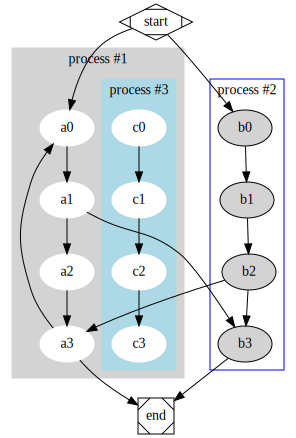

In [37]:
from graphviz import Digraph

g = Digraph('G')

c0 = Digraph('cluster_0')
c0.body.append('style=filled')
c0.body.append('color=lightgrey')
c0.node_attr.update(style='filled', color='white')
c0.edges([('a0', 'a1'), ('a1', 'a2'), ('a2', 'a3')])
c0.body.append('label ="process #1"')

c2 = Digraph('cluster_0')
c2.body.append('style=filled')
c2.body.append('color=lightgrey')
c2.node_attr.update(style='filled', color='white')
c2.edges([('c0', 'c1'), ('c1', 'c2'), ('c2', 'c3')])
c2.body.append('label ="process #3"')
c2.body.append('color=lightblue')
c0.subgraph(c2)

c1 = Digraph('cluster_1')
c1.node_attr.update(style='filled')
c1.edges([('b0', 'b1'), ('b1', 'b2'), ('b2', 'b3')])
c1.body.append('label ="process #2"')
c1.body.append('color=blue')

g.subgraph(c0)
g.subgraph(c1)

g.edge('start', 'a0')
g.edge('start', 'b0')
g.edge('a1', 'b3')
g.edge('b2', 'a3')
g.edge('a3', 'a0')
g.edge('a3', 'end')
g.edge('b3', 'end')

g.node('start', shape='Mdiamond')
g.node('end', shape='Msquare')

g

In [33]:
# sub_scopes='encoder.layer.0.attention.output.LayerNorm'.split('.')

In [34]:
'true' if '' and len(''.split('.')) else 'false'

'false'

In [45]:
sub_scopes='encoder.layer.0.attention.output.LayerNorm'.split('.')
for si in range(len(sub_scopes), 0, -1):
    p_scope = '.'.join(sub_scopes[0:si-1])
    child_scope = '.'.join(sub_scopes[0:si])
    print(si, p_scope, child_scope)

6 encoder.layer.0.attention.output encoder.layer.0.attention.output.LayerNorm
5 encoder.layer.0.attention encoder.layer.0.attention.output
4 encoder.layer.0 encoder.layer.0.attention
3 encoder.layer encoder.layer.0
2 encoder encoder.layer
1  encoder
